In [1]:
import pickle
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pandas import DataFrame
from pandas import concat
from itertools import chain
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Using TensorFlow backend.
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Applications/anaconda3/lib/python3.7/site-packages/t

# 1. 数据加载

In [2]:
# 数据加载
with open('./purchase.pkl', 'rb') as file:
    purchase = pickle.load(file)
purchase = purchase.reset_index()
print(purchase)

with open('./redeem.pkl', 'rb') as file:
    redeem = pickle.load(file)
redeem = redeem.reset_index()
print(redeem)

data = purchase['total_purchase_amt'].values

    report_date  total_purchase_amt
0    2013-07-01            32488348
1    2013-07-02            29037390
2    2013-07-03            27270770
3    2013-07-04            18321185
4    2013-07-05            11648749
..          ...                 ...
422  2014-08-27           302194801
423  2014-08-28           245082751
424  2014-08-29           267554713
425  2014-08-30           199708772
426  2014-08-31           275090213

[427 rows x 2 columns]
    report_date  total_redeem_amt
0    2013-07-01           5525022
1    2013-07-02           2554548
2    2013-07-03           5953867
3    2013-07-04           6410729
4    2013-07-05           2763587
..          ...               ...
422  2014-08-27         468164147
423  2014-08-28         297893861
424  2014-08-29         273756380
425  2014-08-30         196374134
426  2014-08-31         292943033

[427 rows x 2 columns]


In [3]:
# 时序标准化
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
scaled_data = mm.fit_transform(data.reshape(-1, 1))
print(scaled_data[:5])

[[0.02493448]
 [0.02127693]
 [0.01940456]
 [0.00991922]
 [0.00284734]]


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# 2. 训练集构建

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # 拼接到一起
    agg = concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
def get_train_set(data_set, timesteps_in, timesteps_out=1):
    train_data_set = np.array(data_set)
    reframed_train_data_set = np.array(series_to_supervised(train_data_set, timesteps_in, timesteps_out))
    #print(reframed_train_data_set)
    #print(reframed_train_data_set.shape)
    train_x, train_y = reframed_train_data_set[:, :-timesteps_out], reframed_train_data_set[:, timesteps_in:]
    # 将数据集重构为符合LSTM要求的数据格式,即 [样本数，时间步，特征]
    train_x = train_x.reshape((train_x.shape[0],1, timesteps_in))
    print('train_x shape:',train_x.shape)
    print('train_y shape:',train_y.shape)
    return train_x, train_y

In [7]:
timesteps_in = 5
timesteps_out = 1
train_x, label_y=get_train_set(scaled_data, timesteps_in=timesteps_in, timesteps_out=timesteps_out)

train_x shape: (422, 1, 5)
train_y shape: (422, 1)


In [8]:
train_x[:5]

array([[[0.02493448, 0.02127693, 0.01940456, 0.00991922, 0.00284734]],

       [[0.02127693, 0.01940456, 0.00991922, 0.00284734, 0.0294526 ]],

       [[0.01940456, 0.00991922, 0.00284734, 0.0294526 , 0.        ]],

       [[0.00991922, 0.00284734, 0.0294526 , 0.        , 0.05118722]],

       [[0.00284734, 0.0294526 , 0.        , 0.05118722, 0.01890448]]])

In [9]:
label_y[:5]

array([[0.0294526 ],
       [0.        ],
       [0.05118722],
       [0.01890448],
       [0.02303537]])

# 3. 模型与训练

In [20]:
def lstm_model(source_data_set, train_x, label_y, input_epochs, input_batch_size, timesteps_out):
    model = Sequential()
    model.add(LSTM(128,activation="relu",input_shape=(1,train_x.shape[-1])))
    model.add(Dense(timesteps_out))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # LSTM训练 input_epochs次数
    res = model.fit(train_x, label_y, epochs=input_epochs, batch_size=input_batch_size, verbose=2)
    # 模型预测
    train_predict = model.predict(train_x)
    #test_data_list = list(chain(*test_data))
    train_predict_list = list(chain(*train_predict))
    plt.plot(res.history['loss'], label='train')
    plt.show()
    print(model.summary())
    return train_predict

Epoch 1/200
 - 1s - loss: 0.0359
Epoch 2/200
 - 0s - loss: 0.0137
Epoch 3/200
 - 0s - loss: 0.0118
Epoch 4/200
 - 0s - loss: 0.0109
Epoch 5/200
 - 0s - loss: 0.0102
Epoch 6/200
 - 0s - loss: 0.0099
Epoch 7/200
 - 0s - loss: 0.0095
Epoch 8/200
 - 0s - loss: 0.0091
Epoch 9/200
 - 0s - loss: 0.0087
Epoch 10/200
 - 0s - loss: 0.0087
Epoch 11/200
 - 0s - loss: 0.0086
Epoch 12/200
 - 0s - loss: 0.0085
Epoch 13/200
 - 0s - loss: 0.0081
Epoch 14/200
 - 0s - loss: 0.0083
Epoch 15/200
 - 0s - loss: 0.0081
Epoch 16/200
 - 0s - loss: 0.0082
Epoch 17/200
 - 0s - loss: 0.0081
Epoch 18/200
 - 0s - loss: 0.0080
Epoch 19/200
 - 0s - loss: 0.0080
Epoch 20/200
 - 0s - loss: 0.0081
Epoch 21/200
 - 0s - loss: 0.0082
Epoch 22/200
 - 0s - loss: 0.0079
Epoch 23/200
 - 0s - loss: 0.0080
Epoch 24/200
 - 0s - loss: 0.0079
Epoch 25/200
 - 0s - loss: 0.0078
Epoch 26/200
 - 0s - loss: 0.0078
Epoch 27/200
 - 0s - loss: 0.0079
Epoch 28/200
 - 0s - loss: 0.0079
Epoch 29/200
 - 0s - loss: 0.0080
Epoch 30/200
 - 0s - lo

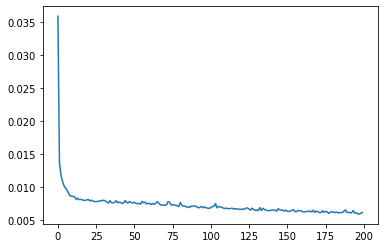

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 68,737
Trainable params: 68,737
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
# 开始训练
epochs = 200
batch_size = 8
train_predict=lstm_model(scaled_data, train_x, label_y, epochs, batch_size, timesteps_out=timesteps_out)

# 4. 结果观察

In [22]:
def plot_img(source_data_set, train_predict):
    plt.figure(figsize=(24, 8))
    # 原始数据蓝色
    plt.plot(source_data_set[:, -1], c='b')
    # 训练数据绿色
    plt.plot([x for x in train_predict], c='g')
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


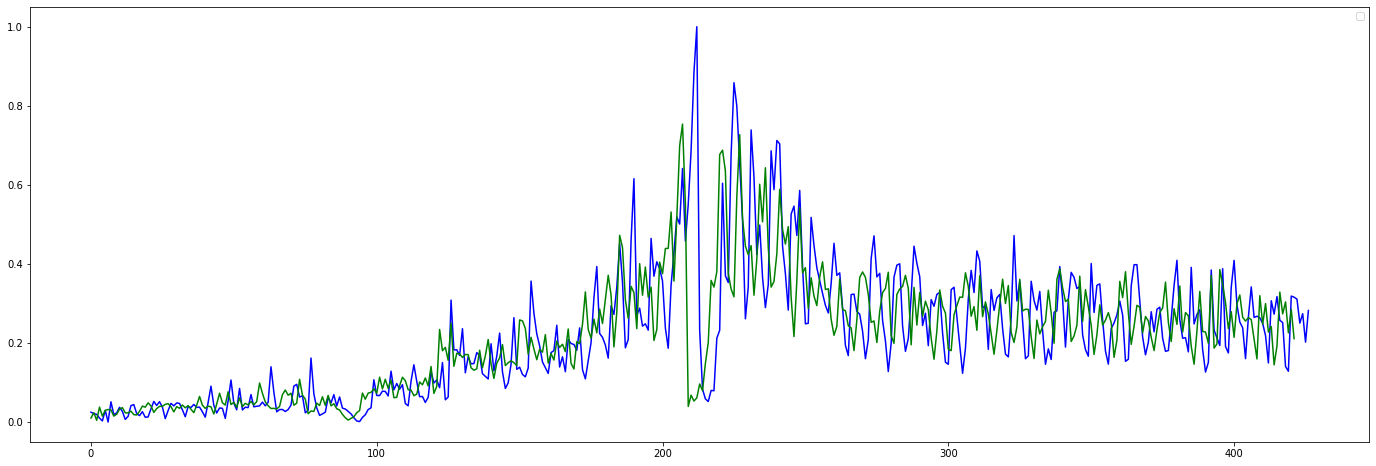

In [23]:
plot_img(scaled_data, train_predict)

In [24]:
# 逆标准化后的真实预测结果
mm.inverse_transform(train_predict)

array([[1.85198280e+07],
       [3.10676340e+07],
       [1.30246690e+07],
       [4.45666760e+07],
       [2.31164200e+07],
       [3.67604520e+07],
       [3.88430680e+07],
       [3.78593040e+07],
       [2.30923020e+07],
       [2.75392240e+07],
       [3.97580200e+07],
       [4.33445800e+07],
       [3.08669540e+07],
       [3.07330940e+07],
       [3.49117800e+07],
       [2.65825600e+07],
       [2.57735300e+07],
       [3.45403040e+07],
       [4.69759320e+07],
       [4.43825280e+07],
       [5.48058960e+07],
       [4.74555600e+07],
       [3.19723620e+07],
       [4.09863400e+07],
       [4.63688040e+07],
       [4.65020120e+07],
       [5.11801160e+07],
       [5.28152960e+07],
       [4.55977560e+07],
       [3.32017260e+07],
       [4.56996680e+07],
       [4.17744600e+07],
       [4.95551960e+07],
       [4.28579280e+07],
       [4.81884320e+07],
       [3.93006480e+07],
       [3.13816460e+07],
       [4.88905360e+07],
       [7.00418640e+07],
       [4.91533960e+07],
